<a href="https://colab.research.google.com/github/bilalProgTech/mtech-data-science/blob/master/Virginia-Tech/Sem-3-Spam-Ham-Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/'

!kaggle datasets download -d veleon/ham-and-spam-dataset
!unzip \*.zip  && rm *.zip

Streaming output truncated to the last 5000 lines.
  inflating: ham/1106.e8f11a2a435c86f57edaf08a726bb72a  
  inflating: ham/1107.7f3b20213d2397c966dfc7defebee2e7  
  inflating: ham/1108.128f9f0247b131505281874efc8e02f8  
  inflating: ham/1109.50269c75e11405ffa85a38881a36e166  
  inflating: ham/1110.607e74a3949cd6e4787031e0164f09ff  
  inflating: ham/1111.682637cab441c4614d42314d8c82c2c6  
  inflating: ham/1112.2e9833f8ba14f5c8fb76c35322ed4a8c  
  inflating: ham/1113.13231f60c358f003d7a4ee9c678bcf66  
  inflating: ham/1114.3ee361561ee25d914e377dd8473a9cb6  
  inflating: ham/1115.e88f46679ef431c8b88cafdd3d21b8ac  
  inflating: ham/1116.e30f22bbdea56cb1ba244a559564ddde  
  inflating: ham/1117.571c1399a9b49bf25062fcd2242d72f1  
  inflating: ham/1118.41f75976258428a527855201ced28007  
  inflating: ham/1119.ce22f4a2ffbc03cd2625cb10ba561058  
  inflating: ham/1120.bec3610a9fcdb3cf5c74d9e60bfbfa1d  
  inflating: ham/1121.51f7e5e557bde451a6b36e527211ed04  
  inflating: ham/1122.0306e263408d376

In [ ]:
import pandas as pd
import numpy as np
import nltk
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns

import email
import email.policy
from bs4 import BeautifulSoup 
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
ham_filenames = [name for name in sorted(os.listdir('/content/hamnspam/ham')) if len(name) > 30]
spam_filenames = [name for name in sorted(os.listdir('/content/hamnspam/spam')) if len(name) > 30]

print('Amount of ham files:', len(ham_filenames))
print('Amount of spam files:', len(spam_filenames))
print('Spam to Ham Ratio:',len(spam_filenames)/len(ham_filenames))

Amount of ham files: 2551
Amount of spam files: 501
Spam to Ham Ratio: 0.1963935711485692


In [ ]:
def load_email(is_spam, filename):
    directory = "/content/hamnspam/spam" if is_spam else "/content/hamnspam/ham"
    with open(os.path.join(directory, filename), "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)
    
ham_emails = [load_email(is_spam=False, filename=name) for name in ham_filenames]
spam_emails = [load_email(is_spam=True, filename=name) for name in spam_filenames]

In [ ]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter

def load_email_test(filename):
    with open(os.path.join(filename), "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)

def get_email_structure(email):
    if isinstance(email, str):
        return email
    payload = email.get_payload()
    if isinstance(payload, list):
        return "multipart({})".format(", ".join([
            get_email_structure(sub_email)
            for sub_email in payload
        ]))
    else:
        return email.get_content_type()

def html_to_plain(email):
    try:
        soup = BeautifulSoup(email.get_content(), 'html.parser')
        return soup.text.replace('\n\n','')
    except:
        return "empty"

def email_to_plain(email):
    struct = get_email_structure(email)
    for part in email.walk():
        partContentType = part.get_content_type()
        if partContentType not in ['text/plain','text/html']:
            continue
        try:
            partContent = part.get_content()
        except: # in case of encoding issues
            partContent = str(part.get_payload())
        if partContentType == 'text/plain':
            return partContent
        else:
            return html_to_plain(part)

def check_for_spam_words(text):
    spam_words = ['please click','offer', 'free', 'congratulations', 'congrats', 
                    'shipping', 'visit website', 'increased', 'adclick', 
                    'fund', 'linux', 'million', 'won', 'lucky number', 'draws']
    text = text.lower()
    if any(word in text for word in spam_words):
        return 1
    return 0

def check_for_exclamation(text):
    return text.count('!')
  
def check_for_currency(text):
    return text.count('£') + text.count('$')

def count_uppercase(text):
    return sum(map(str.isupper, text.split()))

def count_spam_words(text):
    text = text.lower()
    if (text.count('congrats') + text.count('million') + text.count('free') + text.count('congratulations')) >= 3:
        return 1
    return 0

def isWeekend(row):
    if row.dayofweek == 5 or row.dayofweek == 6:
        return 1
    return 0

In [ ]:
def clean_mail(filename):
    t_email = load_email_test(filename)
    t_email_text = email_to_plain(t_email)
    t_email_type = get_email_structure(t_email)
    t_email_date = t_email['Date']

    dict_df = {'email_text': pd.Series(t_email_text), 
               'Date':pd.Series(t_email_date) ,
               'Mail_Type':pd.Series(t_email_type)}
    data = pd.DataFrame(dict_df)
    data['Date'] = pd.to_datetime(data['Date'].str[0:25], format='%a, %d %b %Y %H:%M:%S', errors='coerce')
    data['Mail_Type'] = LabelEncoder().fit_transform(data['Mail_Type'])

    input_df = pd.DataFrame()
    input_df['isSpamWords'] = data['email_text'].apply(lambda x: check_for_spam_words(x))
    input_df['numExclamation'] = data['email_text'].apply(lambda x: check_for_exclamation(x))
    input_df['Length'] = data['email_text'].str.len()
    input_df['numUppercaseWords'] = data['email_text'].apply(lambda x: count_uppercase(x))
    input_df['countCurrency'] = data['email_text'].apply(lambda x: check_for_currency(x))
    input_df['isRepeatedSpamWords'] = data['email_text'].apply(lambda x: count_spam_words(x))
    input_df['Weekday'] = data['Date'].dt.weekday
    input_df['Month'] = data['Date'].dt.month
    input_df['isWeekend'] = data['Date'].apply(lambda x: isWeekend(x))
    input_df['Mail_Type'] = data['Mail_Type']
    input_df = input_df.dropna()
    input_df = input_df.astype('int64')
    return input_df

In [ ]:
ham_text = [email_to_plain(ham_emails[i]) for i in range(len(ham_emails))]
spam_text = [email_to_plain(spam_emails[i]) for i in range(310)]

ham_type = [get_email_structure(ham_emails[i]) for i in range(len(ham_emails))]
spam_type = [get_email_structure(spam_emails[i]) for i in range(310)]

spam_dates = [spam_emails[i]['Date'] for i in range(len(spam_emails)) if i < 310]
ham_dates = [ham_emails[i]['Date'] for i in range(len(ham_emails))]

data = pd.DataFrame({'email_text': ham_text, 'label':[0]*len(ham_emails), 'Date': ham_dates, 'Mail_Type':ham_type})
data = pd.concat([data, pd.DataFrame({'email_text': spam_text, 'label':[1]*310, 'Date': spam_dates, 'Mail_Type':spam_type})])

data['Mail_Type'] = LabelEncoder().fit_transform(data['Mail_Type'])

data['Date'] = pd.to_datetime(data['Date'].str[0:25], format='%a, %d %b %Y %H:%M:%S', errors='coerce')
data = data.sample(frac=1)
data = data.reset_index(drop=True)
data.head(10)

,email_text,label,Date,Mail_Type
0,URL: http://www.askbjoernhansen.com/archives/2...,0,2002-10-01 08:01:46,20
1,"Dear Sir or Madam,\n\nMy name is Petr Stanek a...",1,2002-09-04 16:51:20,20
2,"Date: Wed, 21 Aug 2002 10:40:39 -05...",0,2002-08-22 21:55:18,20
3,use Perl Daily Headline Mailer\n\nThis Week on...,0,2002-10-08 02:00:26,20
4,\nForwarded-by: Nev Dull <nev@sleepycat.com>\n...,0,2002-09-05 10:26:01,20
5,jm@jmason.org (Justin Mason) writes:\n\n> exce...,0,2002-09-25 13:54:17,20
6,"Date: Thu, 22 Aug 2002 10:04:06 -05...",0,2002-08-24 18:56:05,20
7,I've had this binding in my ~/.exmh/exmhbindin...,0,2002-10-01 23:22:14,20
8,LOL! They're not doomed at all. Thousands of...,0,2002-09-05 16:40:13,20
9,\nValdis.Kletnieks@vt.edu said:\n> I checked o...,0,2002-08-27 00:38:05,20


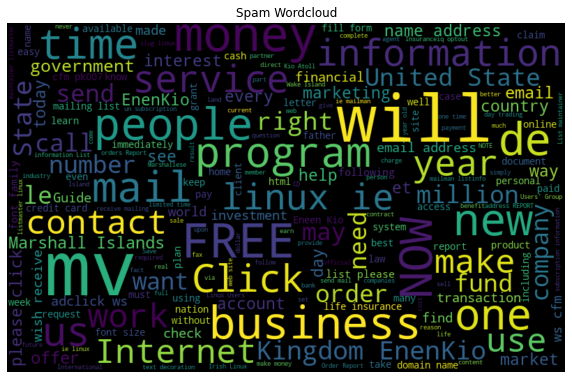

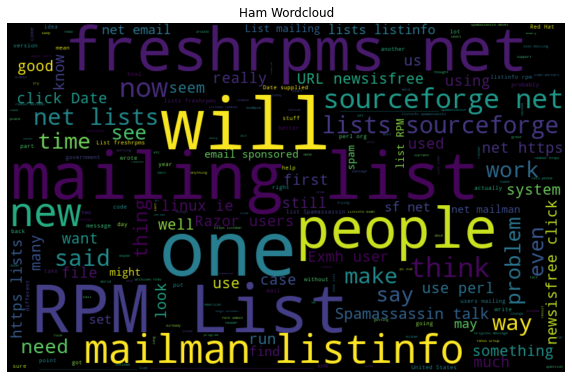

In [ ]:
from wordcloud import WordCloud

spam = data[data['label'] == 1]
ham = data[data['label'] == 0]

all_words = ' '.join([text for text in spam['email_text']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Spam Wordcloud')
plt.axis('off')
plt.show()
all_words = ' '.join([text for text in ham['email_text']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Ham Wordcloud')
plt.axis('off')
plt.show()

In [ ]:
input_df = pd.DataFrame()
input_df['isSpamWords'] = data['email_text'].apply(lambda x: check_for_spam_words(x))
input_df['numExclamation'] = data['email_text'].apply(lambda x: check_for_exclamation(x))
input_df['Length'] = data['email_text'].str.len()
input_df['numUppercaseWords'] = data['email_text'].apply(lambda x: count_uppercase(x))
input_df['countCurrency'] = data['email_text'].apply(lambda x: check_for_currency(x))
input_df['isRepeatedSpamWords'] = data['email_text'].apply(lambda x: count_spam_words(x))
input_df['Weekday'] = data['Date'].dt.weekday
input_df['Month'] = data['Date'].dt.month
input_df['isWeekend'] = data['Date'].apply(lambda x: isWeekend(x))
input_df['Mail_Type'] = data['Mail_Type']
input_df['label'] = data['label']
input_df = input_df.dropna()
input_df = input_df.sample(frac=1).reset_index(drop=True)
input_df = input_df.astype('int64')
input_df.head(10)

,isSpamWords,numExclamation,Length,numUppercaseWords,countCurrency,isRepeatedSpamWords,Weekday,Month,isWeekend,Mail_Type,label
0,0,0,1180,1,0,0,3,8,0,20,0
1,1,16,2904,33,0,1,3,8,0,20,1
2,0,0,1068,7,0,0,3,8,0,20,0
3,1,0,105,2,0,0,1,10,0,20,0
4,0,0,557,5,0,0,1,9,0,20,0
5,1,1,1554,6,0,0,4,9,0,20,0
6,1,0,1581,11,0,0,4,9,0,20,0
7,1,1,1646,9,0,0,3,8,0,20,0
8,0,0,127,0,0,0,4,9,0,20,0
9,1,0,833,0,0,0,6,10,1,20,0


In [ ]:
pd.crosstab(input_df['isSpamWords'],input_df['label'])

label,0,1
isSpamWords,,
0,1382,97
1,1169,202


In [ ]:
pd.crosstab(input_df['isRepeatedSpamWords'],input_df['label'])

label,0,1
isRepeatedSpamWords,,
0,2492,236
1,59,63


In [ ]:
pd.crosstab(input_df['isWeekend'],input_df['label'])

label,0,1
isWeekend,,
0,2248,233
1,303,66


In [ ]:
pd.crosstab(input_df['Weekday'],input_df['label'])

label,0,1
Weekday,,
0,420,38
1,466,31
2,473,37
3,577,54
4,312,73
5,143,37
6,160,29


In [ ]:
pd.crosstab(input_df['Mail_Type'],input_df['label'])

label,0,1
Mail_Type,,
0,0,3
1,1,0
2,0,9
3,0,2
4,0,1
5,3,6
6,1,0
7,2,1
8,72,0


In [ ]:
pd.crosstab(input_df['Month'],input_df['label']).T

Month,1,2,6,7,8,9,10
label,,,,,,,
0,1,43,0,0,527,1238,742
1,0,0,1,8,190,100,0


In [ ]:
agg_op = ['mean', 'min', 'max']

In [ ]:
input_df.groupby(['label'])[['numExclamation']].agg(agg_op)

numExclamation        
                mean min max
label                       
0           0.540964   0  47
1           4.702341   0  55

In [ ]:
input_df.groupby(['label'])[['Length']].agg(agg_op)

Length           
              mean min    max
label                        
0      1413.033712  47  88024
1      2093.344482   1  71613

In [ ]:
input_df.groupby(['label'])[['numUppercaseWords']].agg(agg_op)

numUppercaseWords         
                   mean min  max
label                           
0              7.014504   0  189
1             24.538462   0  431

In [ ]:
input_df.groupby(['label'])[['countCurrency']].agg(agg_op)

countCurrency         
               mean min  max
label                       
0          0.393571   0  148
1          2.795987   0  218

In [ ]:
input_df.isnull().sum()

isSpamWords            0
numExclamation         0
Length                 0
numUppercaseWords      0
countCurrency          0
isRepeatedSpamWords    0
Weekday                0
Month                  0
isWeekend              0
Mail_Type              0
label                  0
dtype: int64

In [ ]:
input_df['label'].value_counts()

0    2551
1     299
Name: label, dtype: int64

In [ ]:
input_df.columns

Index(['isSpamWords', 'numExclamation', 'Length', 'numUppercaseWords',
       'countCurrency', 'isRepeatedSpamWords', 'Weekday', 'Month', 'isWeekend',
       'Mail_Type', 'label'],
      dtype='object')

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, r2_score
from sklearn import tree

In [ ]:
from sklearn.model_selection import train_test_split

X = input_df.drop(['label'], axis=1)
y = input_df['label']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [ ]:
lm_model = LogisticRegression(max_iter=1000)
lm_model.fit(x_train, y_train)

pred_test = lm_model.predict(x_test)
prob_test = lm_model.predict_proba(x_test)[:,-1]

print('Accuracy: ', accuracy_score(pred_test, y_test))
print('AUC Score: ', roc_auc_score(y_test, prob_test))
print('R2 Train: ', lm_model.score(x_train, y_train))

Accuracy:  0.9122807017543859
AUC Score:  0.7737142857142858
R2 Train:  0.9220272904483431


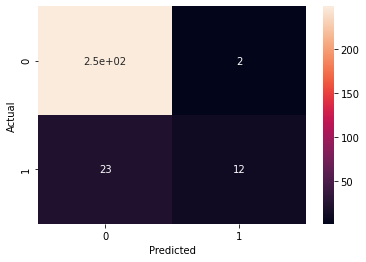

In [ ]:
df_cm = pd.DataFrame(confusion_matrix(y_test, pred_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sns.heatmap(df_cm, annot=True)

In [ ]:
tree_model = DecisionTreeClassifier(max_depth=10)
tree_model.fit(x_train, y_train)

pred_test = tree_model.predict(x_test)
prob_test = tree_model.predict_proba(x_test)[:,-1]

print('Accuracy: ', accuracy_score(pred_test, y_test))
print('AUC Score: ', roc_auc_score(y_test, prob_test))
print('R2 Train: ', tree_model.score(x_train, y_train))

Accuracy:  0.9508771929824561
AUC Score:  0.8809714285714287
R2 Train:  0.9925925925925926


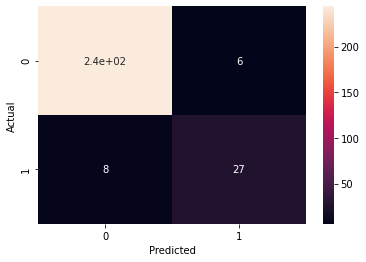

In [ ]:
df_cm = pd.DataFrame(confusion_matrix(y_test, pred_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sns.heatmap(df_cm, annot=True)

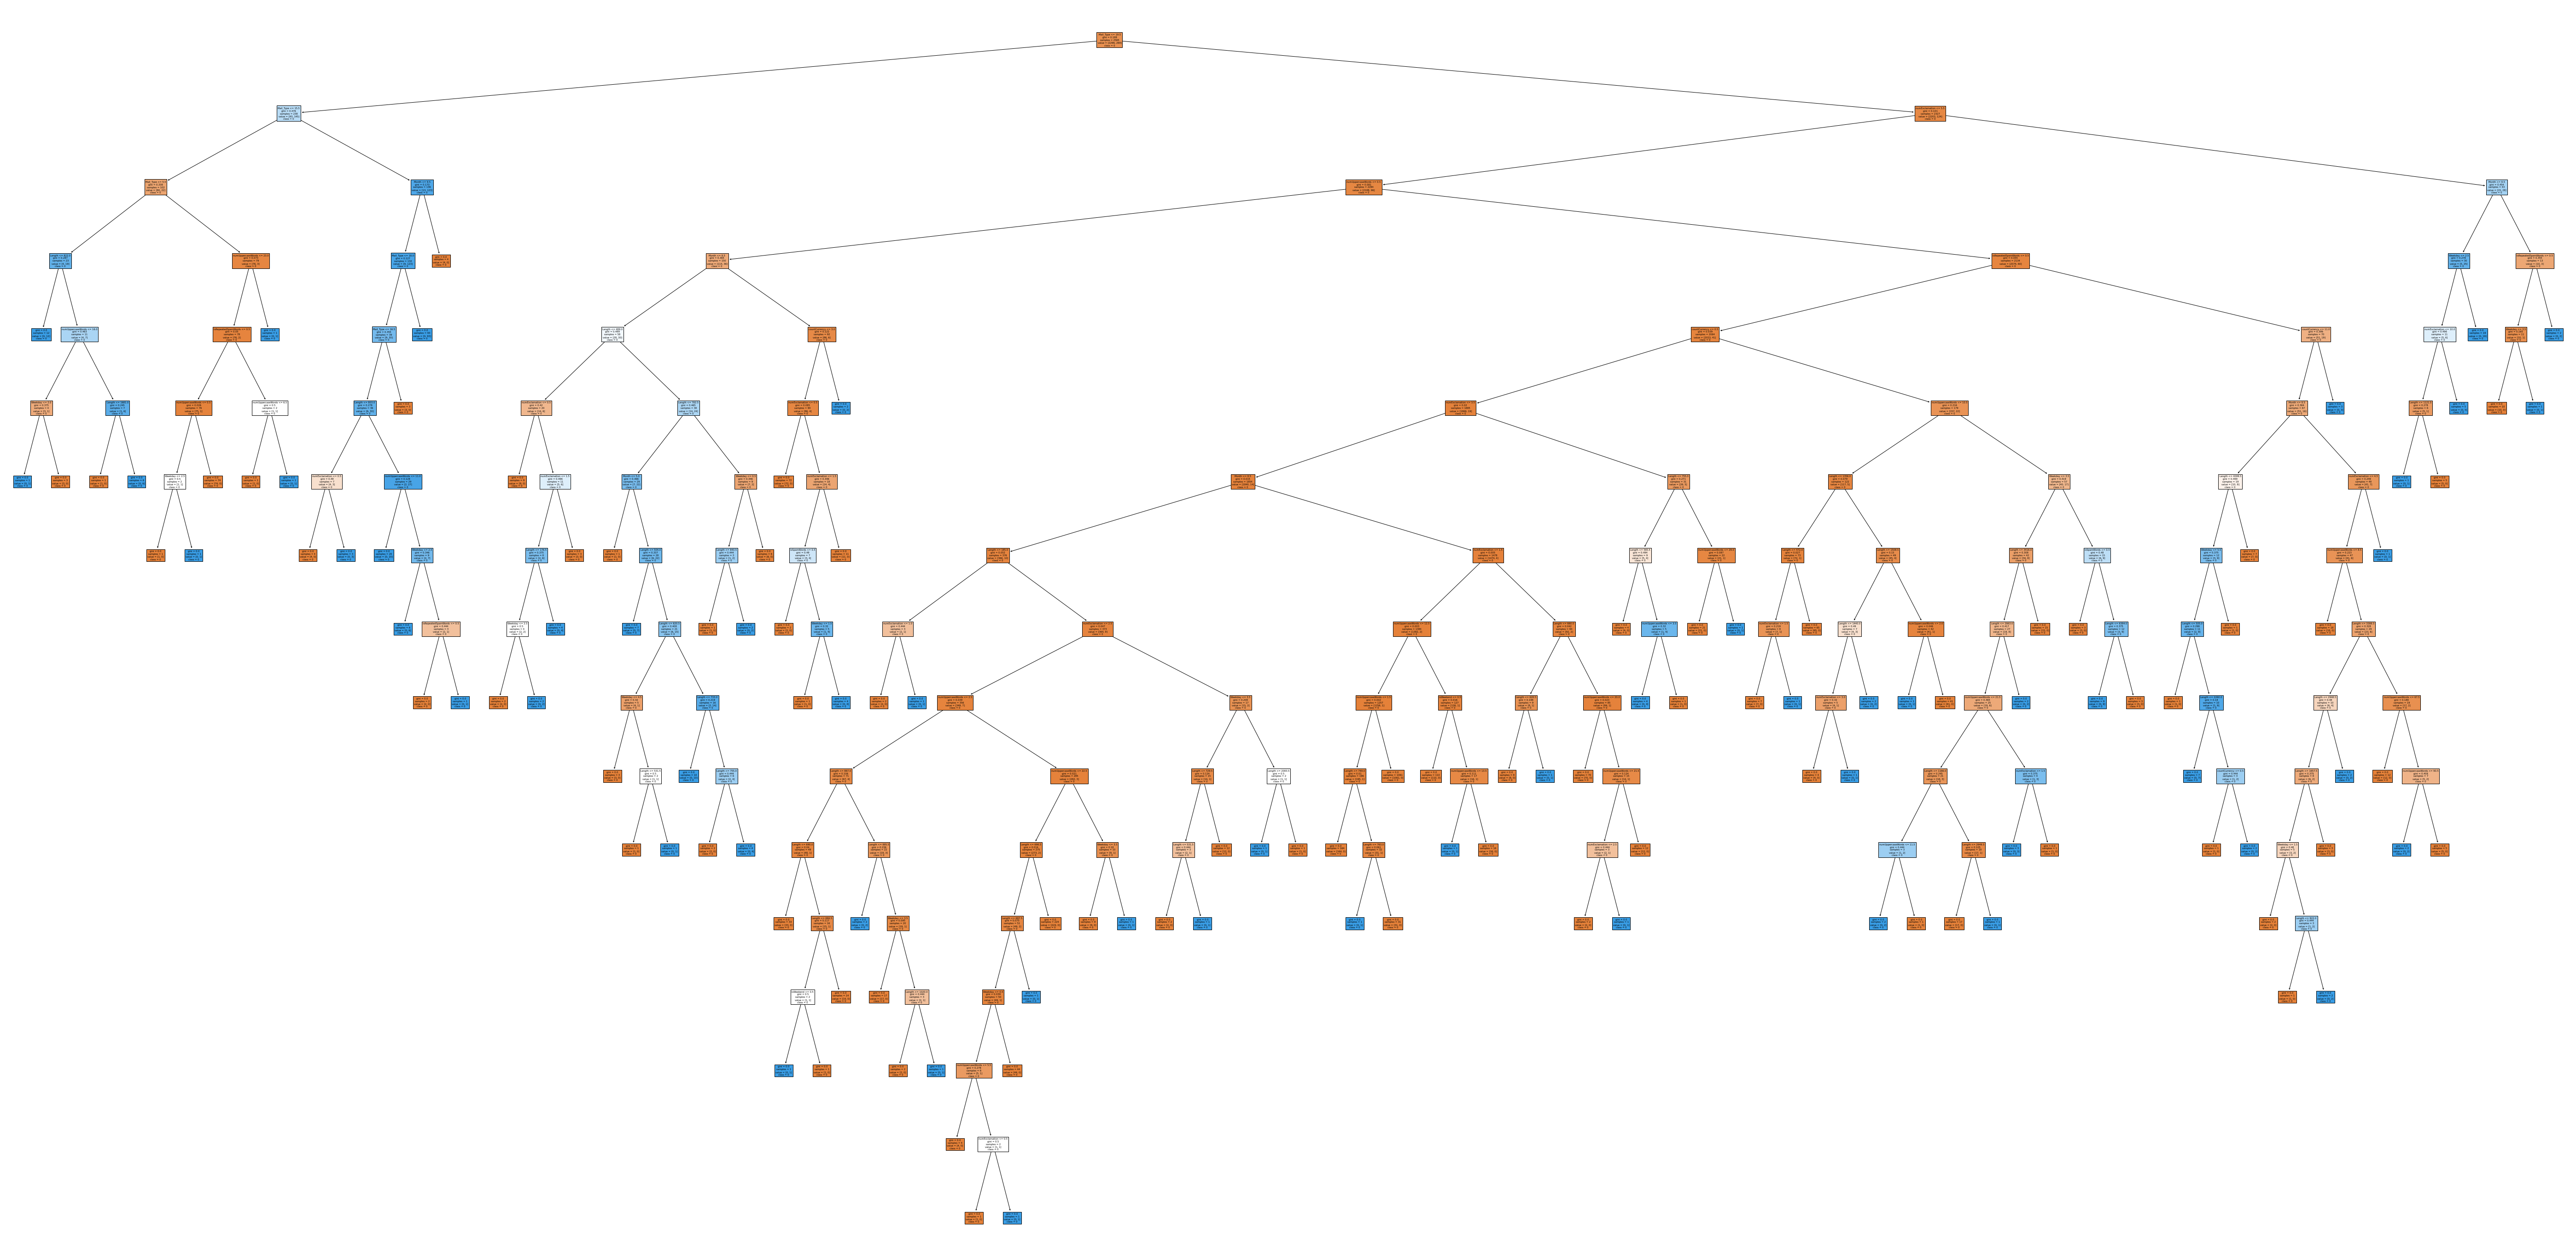

In [ ]:
fig = plt.figure(figsize=(100,50))
_ = tree.plot_tree(tree_model,
                   feature_names=X.columns,  
                   class_names=y.astype('str'),
                   filled=True)

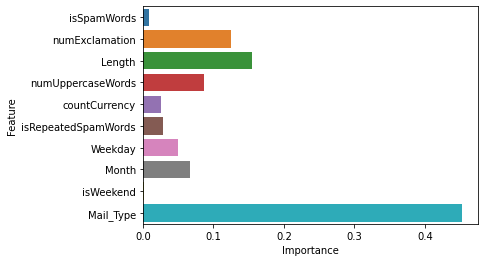

In [ ]:
feat_imp = pd.DataFrame({'Feature':X.columns, 'Importance':tree_model.feature_importances_})
sns.barplot(x='Importance', y='Feature', data=feat_imp)

In [ ]:
mail_title = []
predictions = []
actual = [1,0,0,1,1,0,1,0,0,1]
for name in sorted(os.listdir('/content/test_email/')):
    mail_title.append(name)
    testing_mail = clean_mail('/content/test_email/'+name)
    predictions.append(lm_model.predict(testing_mail).tolist())

output_df = pd.DataFrame({'Mail Subject': mail_title, 
                          'Google Mail Classification': actual,
                          'Logistic Reg. Predictions': sum(predictions, [])})
output_df['Google Mail Classification'] = np.where(output_df['Google Mail Classification'] == 0, "Ham", "Spam")
output_df['Logistic Reg. Predictions'] = np.where(output_df['Logistic Reg. Predictions'] == 0, "Ham", "Spam")

In [ ]:
mail_title = []
predictions = []
for name in sorted(os.listdir('/content/test_email/')):
    mail_title.append(name)
    testing_mail = clean_mail('/content/test_email/'+name)
    predictions.append(tree_model.predict(testing_mail).tolist())

output_df['Decision Tree Predictions'] = np.where(np.array(sum(predictions, [])) == 0, "Ham", "Spam")
output_df

,Mail Subject,Google Mail Classification,Logistic Reg. Predictions,Decision Tree Predictions
0,FREE Java Internship.eml,Spam,Spam,Ham
1,Get Offers from Top U.S. Software Companies! 2...,Ham,Ham,Spam
2,Learn on Dataquest for FREE — this week only!.eml,Ham,Spam,Spam
3,MADE EASY PRIME _ GATE 2021 Online Course.eml,Spam,Ham,Spam
4,More related to _How currency demonetization a...,Spam,Ham,Ham
5,Open Government Data Platform_ From Data to In...,Ham,Spam,Ham
6,PCH59472893656.eml,Spam,Ham,Spam
7,The Overflow #40_ Tech in _Rest of the World_.eml,Ham,Spam,Spam
8,[Webinar] Career Transition Into Data Science ...,Ham,Ham,Spam
9,"iamhungundji, scholarships available to study ...",Spam,Spam,Spam
